In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sp
import os

# data path, constants, etc.
import sys
atompath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(atompath)
datapath = '/Users/nhamilto/Documents/ATom/coderepo/calibration_data/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import atom_functions as atom

In [2]:
from scipy import optimize

def cosine_fit_func(x, a, b, c):
    return a * np.cos(b * x)+c

### Speaker characterization data
signal latency at several fixed radial distances from the center of the speaker aperature as a function of azimuth angle

In [4]:
colnames = ['azangle'] + [x for x in range(120)]
speaker = pd.read_csv(os.path.join(datapath,'speaker_char_raw_data_210818.csv'), names=colnames, skiprows=1)

speaker['azangle'].ffill(inplace=True)
speaker = speaker.set_index('azangle').drop('4m', axis=0)
speaker.set_index(pd.to_numeric(speaker.index), inplace=True)
speaker['radius'] = np.concatenate(((2*np.ones(int(len(speaker.index)/2))).astype(int), (4*np.ones(int(len(speaker.index)/2+1))).astype(int)))
speaker.reset_index(inplace=True)
speaker.set_index(['radius','azangle'], inplace=True)


- calculate mean offset time,
- exclude outliers,
- separate by radial distance, 
- subtract minimum value, 

In [5]:
# get mean values over 120 records
meanoff = speaker.T.mean()

# remove and replace obvious outliers
meanoff.loc[2,[-40,40]] = np.nan
meanoff.interpolate(inplace=True)
meanoff.loc[4,[-100]] = np.nan
meanoff.bfill(inplace=True)

# extract data for radial distance = 2 m
rad2 = meanoff.xs(2, level=0) - meanoff.xs(2, level=0).min()
rad2 = rad2.reset_index()
rad2.columns = ['azangle', 'offset']

# extract data for radial distance = 4 m
rad4 = meanoff.xs(4, level=0) - meanoff.xs(4, level=0).min()
rad4 = rad4.reset_index()
rad4.columns = ['azangle', 'offset']

# fit cosine curve to data
rad2params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad2['azangle']), rad2['offset'], p0=[0.15, 2, 0.15])
rad4params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad4['azangle']), rad4['offset'], p0=[0.15, 2, 0.15])

rad2fit = cosine_fit_func(np.radians(rad2['azangle']), rad2params[0], rad2params[1], rad2params[2])
rad4fit = cosine_fit_func(np.radians(rad4['azangle']), rad4params[0], rad4params[1], rad4params[2])

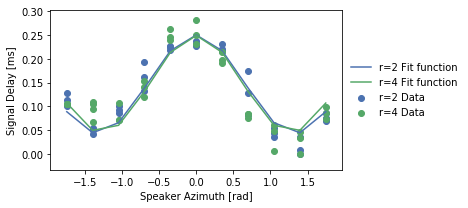

In [7]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.radians(rad2['azangle']), rad2['offset'], label='r=2 Data')
ax.plot(np.radians(rad2['azangle']), rad2fit,
         label='r=2 Fit function')

ax.scatter(np.radians(rad4['azangle']), rad4['offset'], label='r=4 Data', color='C1')
ax.plot(np.radians(rad4['azangle']), rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Speaker Azimuth [rad]')
ax.set_ylabel('Signal Delay [ms]')

fig.tight_layout()
fig.savefig(os.path.join(datapath,'speaker_char_time_offsets.png'), dpi=200, bbox_inches='tight')

### Signal latency
Time delays produced by the particulasr equipment in use can be another factor in accuracy of the AT array

In [9]:
colnames = ['Speaker', 'Mic'] + [x for x in range(120)]
latency = pd.read_csv(os.path.join(datapath,'latency_characterization_210818.csv'),
                      names=colnames)#, skiprows=1)

latency[['Speaker', 'Mic']] = latency[['Speaker', 'Mic']].ffill()#inplace=True)
latency.set_index(['Speaker', 'Mic'], inplace=True)

# interpolate over missing data?
latency = latency.interpolate(axis=1)

meanlat = latency.T.mean()
meanlat = pd.DataFrame(meanlat)
meanlat = meanlat.groupby(['Speaker', 'Mic']).mean().unstack()

In [10]:
meanlat.style.background_gradient(cmap='viridis', low=0.75, high=-0.25)

In [12]:
# write to file!
meanlat.to_csv(os.path.join(datapath,'average_latency_220818.csv'))


### Instrument locations

In [40]:
# read locations data
locations = pd.read_csv(os.path.join(datapath,'NWTC_tomography_robotic.csv'), 
                        names=['ID','northing','easting','elevation','device','subarea'])
# missing data included later
locations_addendum = pd.read_csv(os.path.join(datapath,'NWTC_Tomography_Add.csv'), 
                                 names=['ID','northing','easting','elevation','device','subarea'])
locations_addendum['device'] = ['SPEAKER 2', 'SPEAKER 4']
locations_addendum['subarea'] = ['MIC','MIC']
locations = pd.concat([locations, locations_addendum],ignore_index=True)

In [41]:
locations.drop('ID', axis=1, inplace=True)
locations.set_index(['device','subarea'], inplace=True)

reindex = list(set(locations.index.get_level_values(0)))
reindex.sort()
reindex = ['Station {}'.format(int(x+1)) for x in [7,0,1,2,3,4,5,6]]
locations.T.columns.set_levels(reindex,level=0,inplace=True)
locations.sort_index(inplace=True)


In [42]:
# extract microphone positions
mics = locations.xs('MIC', level=1)

# extract speaker positions positions
speakers = locations.drop('MIC', level=1)
speakerlocs = speakers.mean(level=0)


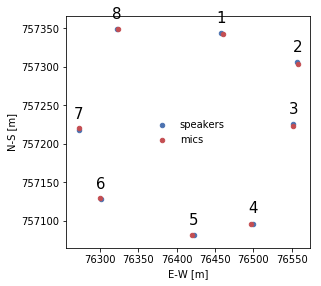

In [69]:
fig, ax = plt.subplots()
speakerlocs.plot.scatter(x='easting', y='northing', ax=ax)
mics.plot.scatter(x='easting', y='northing', ax=ax, color='C2')

for ii in range(8):
    t = ax.text(speakerlocs['easting'].iloc[ii], speakerlocs['northing'].iloc[ii]+10, str(ii+1), ha="center", va="bottom", size=15,)
    
ax.set_xlabel('E-W [m]')
ax.set_ylabel('N-S [m]')

ax.set_aspect('equal', 'box')

ax.legend(['speakers', 'mics'], frameon=False, loc=10)

fig.tight_layout()

fig.savefig('../figures/inst_locations.png', dpi=200, bbox_inches='tight')

### Estimate locations of missing mics
for Station 2, estimate mic location as the average distance between speakers and mics, in the direction of Station 3.

for Station 4, estimate mic location as the average distance between speakers and mics, in the direction of Station 5.

In [11]:
micoffsets = mics - speakerlocs
micoffsets['dist'] = np.sqrt(micoffsets['northing']**2 + micoffsets['easting']**2 + micoffsets['elevation']**2)

avdist = micoffsets['dist'].mean()
avelevation = micoffsets['elevation'].mean()

micoffsets

,northing,easting,elevation,dist
device,,,,
Station 1,-1.17175,2.00775,0.03875,2.324986
Station 2,NaN,NaN,NaN,NaN
Station 3,-2.30100,-0.42625,-0.19475,2.348237
Station 4,NaN,NaN,NaN,NaN
Station 5,0.33600,-2.24775,0.00625,2.272733
Station 6,1.98675,-1.21825,0.06650,2.331465
Station 7,2.23300,0.27700,0.06375,2.251018
Station 8,0.87750,2.15400,0.07025,2.326942


In [14]:
dely = speakerlocs['northing'].iloc[2] - speakerlocs['northing'].iloc[1]
delx = speakerlocs['easting'].iloc[2] - speakerlocs['easting'].iloc[1]
dir23 = np.arctan2(dely, delx)

dely = speakerlocs['northing'].iloc[4] - speakerlocs['northing'].iloc[3]
delx = speakerlocs['easting'].iloc[4] - speakerlocs['easting'].iloc[3]
dir45 = np.arctan2(dely, delx)

# temp = micoffsets.copy()
micoffsets.loc['Station 2'] = [np.sin(dir23)*avdist, np.cos(dir23)*avdist, avelevation, avdist]
micoffsets.loc['Station 4'] = [np.sin(dir45)*avdist, np.cos(dir45)*avdist, avelevation, avdist]

In [15]:
mics = speakerlocs + micoffsets
mics.drop('dist',axis=1, inplace=True)
mics = mics[['northing', 'easting', 'elevation']]


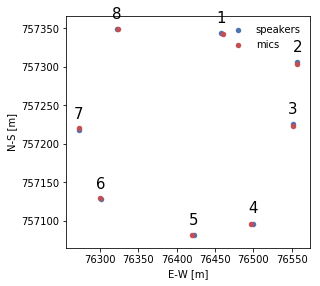

In [16]:
fig, ax = plt.subplots()
speakerlocs.plot.scatter(x='easting', y='northing', ax=ax)
mics.plot.scatter(x='easting', y='northing', ax=ax, color='C2')

for ii in range(8):
    t = ax.text(speakerlocs['easting'].iloc[ii], speakerlocs['northing'].iloc[ii]+10, str(ii+1), ha="center", va="bottom", size=15,)
    
ax.set_xlabel('E-W [m]')
ax.set_ylabel('N-S [m]')

ax.set_aspect('equal', 'box')

ax.legend(['speakers', 'mics'], frameon=False)

fig.tight_layout()
fig.savefig('../figures/inst_locations_add_missing.png', dpi=200, bbox_inches='tight')

### Save data!

In [55]:
mics.to_csv('../calibration_data/mic_locations_20180924.csv')
speakerlocs.to_csv('../calibration_data/speaker_locations_20180924.csv')

### compare new mic data to old

In [56]:
oldmics = np.array([[757342.515     ,  76460.405     ,   6094.11      ],
       [757304.32830741,  76556.79205156,   6094.13970833],
       [757223.495     ,  76551.17      ,   6093.872     ],
       [757095.62776897,  76497.0359615 ,   6094.20970833],
       [757081.445     ,  76420.334     ,   6094.116     ],
       [757129.534     ,  76299.993     ,   6094.066     ],
       [757220.544     ,  76273.092     ,   6094.115     ],
       [757349.609     ,  76324.109     ,   6094.266     ]])

In [65]:
offsetdist = np.array(mics)-oldmics
offsetdist = np.sqrt(offsetdist[:,0]**2 +
                     offsetdist[:,1]**2 + 
                     offsetdist[:,2]**2)
print('offset between new mic and old locations [m]:') 
print(offsetdist.round(3)) 

offset between new mic and old locations [m]:
[0.    0.81  0.    0.467 0.    0.    0.    0.   ]


In [71]:
np.array(mics)

array([[757342.515,  76460.405,   6094.11 ],
       [757304.419,  76557.597,   6094.15 ],
       [757223.495,  76551.17 ,   6093.872],
       [757095.2  ,  76497.122,   6094.042],
       [757081.445,  76420.334,   6094.116],
       [757129.534,  76299.993,   6094.066],
       [757220.544,  76273.092,   6094.115],
       [757349.609,  76324.109,   6094.266]])

In [73]:
np.array(speakerlocs)

array([[757343.68675,  76458.39725,   6094.07125],
       [757306.6325 ,  76556.9445 ,   6094.13125],
       [757225.796  ,  76551.59625,   6094.06675],
       [757096.06975,  76499.3025 ,   6094.20125],
       [757081.109  ,  76422.58175,   6094.10975],
       [757127.54725,  76301.21125,   6093.9995 ],
       [757218.311  ,  76272.815  ,   6094.05125],
       [757348.7315 ,  76321.955  ,   6094.19575]])